# How first-time airbnb users decide where to travel
***

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

### Airbnb challenges you to predict in which destination country a new user from the USA will make his or her first booking:
1. United States of America
2. France
3. Canada
4. Great Britain
5. Spain
6. Italy
7. Portugal
8. Netherlands
9. Germany
10. Australia  
11. No Destination Found (NDF) 
12. Other


### Known issues
1. before early 2013 users could make bookings without creating an account
2. where *date_first_booking* is populated with *NAN* the destination country is also given as NDF


### Questions that I would like to explore using the summary data provided are:
1. Are there missing data or data munging that need to be done?
2. Are there any outliers?
3. What are the similarities/differences in the destination countries?
4. Demographic differences that could point to preferences?
5. Investigate the impact that user interaction with the website has on destination selection.

In [3]:
# load libraries that will be used
%matplotlib inline

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from mpl_toolkits.basemap import Basemap

# make figures better:
font = {'weight':'normal','size':20}
plt.rc('font', **font)
plt.rc('figure', figsize=(9.0, 6.0))
plt.rc('xtick.major', pad=10) # xticks too close to border!
plt.style.use('ggplot')
plt.set_cmap('Set3')
#print(plt.style.available)

In [5]:
# load data
%run load.py

df_countries => rows: 10; columns: 7
df_country_demographics => rows: 420; columns: 5
df_user_sessions => rows: 10567737; columns: 6
df_train => rows: 213451; columns: 16
df_test => rows: 62096; columns: 15
df_users => rows: 275547; columns: 16


***
## Ten potential countries to explore, which are they more likely to choose?

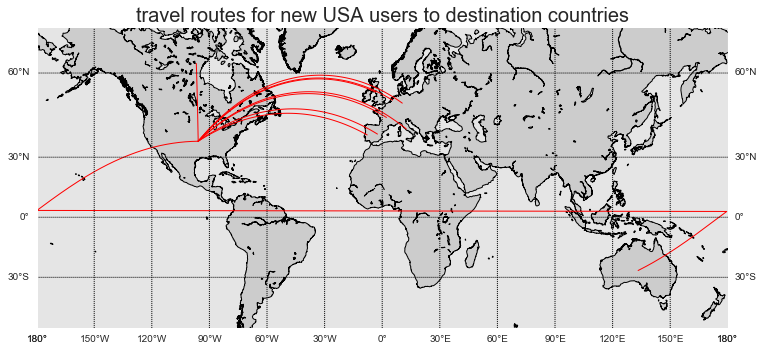

In [6]:
# create new figure, axes instances.
fig=plt.figure(figsize=(12,9))
ax=fig.add_axes([0.1,0.1,0.8,0.8])

# setup mercator map projection as map background
m = Basemap(llcrnrlon=-180.,llcrnrlat=-50.,urcrnrlon=180.,urcrnrlat=70.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)

# draw great circle route between USA and destination countries
dest_lon = df_countries.lng_destination
dest_lat = df_countries.lat_destination
usa_lon = dest_lon[9]
usa_lat = dest_lat[9]
destinations = len(df_countries.country_destination)-1 # minus one in order to exclude USA at the end
for i in range(destinations):
    m.drawgreatcircle(usa_lon, usa_lat, dest_lon[i], dest_lat[i], linewidth=1, color='r')

# draw map details
m.drawcoastlines()
m.fillcontinents()
# draw parallels
m.drawparallels(np.arange(-60,90,30),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

ax.set_title('travel routes for new USA users to destination countries', size=20)
plt.show()

The above picture highlights the fact that the majority, 7 out of the 10 destination coutries, lie within the Europe. Part of the appeal of going to at least 6 out of the 10 countries is that they are all within the European Union which makes it easy to move between the countries, as well as having the same currency. This brings up the possiblity that the choosen destination country might be favoured as a starting point for a trip around Europe and with the idea of staying in a country for the whole duration of the trip.

On the other side of the spectrum, I would group the USA, Canada and Australia under the umbrella of being large countries with lots to explore so you would tend to stay within these countries for the duration of the trip and not venture to other countries as part of the trip. Canada could be of interest to an American tourist because of it's proximity and the linked currency means there is no exchange rate risk to bump up the budgeted cost of a trip. Canada also hold a lot of natural splendour and you could practice your French in Montreal. Australia on the other hand is the only country from the southern hemisphere and could hold appeal beacuse of it's exotic wild life, beaches and more. Likewise the USA hold many attractions and most Americans tend to holiday within their own country.

According to [data](http://travel.trade.gov/view/m-2015-O-001/index.html) released by the U.S. Department of Commerce, International Trade Administration, National Travel and Tourism Office (NTTO) on 29 December 2015; 61,322,698 U.S. citizens traveled to international regions in the first 10 months of 2015. About 54.9% was to either Mexico (22,641,533 U.S. citizens; 36.9% of total) and Canada (11,008,848; 18%). All of Europe saw just above the number of U.S. citizens as Canada (11,067,879; 18% of total), but half that of Mexico and Oceania (used as proxy for Australia in this example) saw 0.8% (511,563) of U.S. citizens come to their shores in 2015. 

Based on this supporting data, my hunch is that U.S. Citizens are more likely to favour Canada and European countries to Australia. And with 458.3 million business trips and 1,692.8 million leisure trips by U.S. citizens in [2015](http://www.statista.com/statistics/207103/forecasted-number-of-domestic-trips-in-the-us/), I'm confident that domestic travel within the USA would hold great appeal to USA users of airbnb as well. 

***
## How do the demographics within countries differ between countries? 

So it looks like this dataset is a summary of gender and age band per destination country as at 2015. The source is unclear, but it ties up with what I've found through Google searches.

But what else can it tell us?

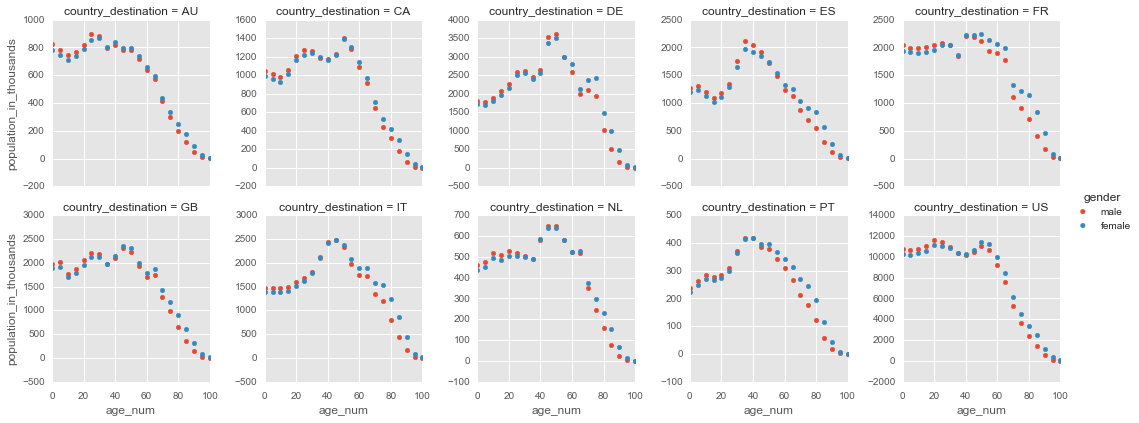

In [7]:
df_country_demographics['age_num'] = df_country_demographics['age_bucket'].map(lambda x: int(x[:str.find(x,'-')]))

g = sns.FacetGrid(df_country_demographics, col="country_destination", hue="gender", 
                    col_wrap=5, xlim=[0,100] ,sharey=False)
g = g.map(plt.scatter, "age_num", "population_in_thousands")
g.add_legend();

It's not clear at this stage what value these country related demographics will have on whether users choose a specific country. But from the distribution of dots above it is clear that the highest proportion of people are in the 40 to 59 age range, but Cananda, Great Britian, and the USA have a two "humps" (bi-modal distrubtion) with significant proportion of the population in the 20 to 24 age band. While the largest portion of Australia's population sit in the 20-24 bracket. 

Gender distributions also tend to be quite similar and females tend to outlive males between the ages of 60 to 99. 

***
## Who are airbnb's first time users?
Now that we know more about where they could want to go and why and how they are interacting the website.

In [8]:
print("Number of users in the training set: %0.0f; \n\
Number of users in the test set: %0.0f" % (np.shape(df_train)[0], np.shape(df_test)[0]))
print("Full Set Rows: %0.0f; -Columns: %0.0f" % np.shape(df_users))

Number of users in the training set: 213451; 
Number of users in the test set: 62096
Full Set Rows: 275547; -Columns: 16


### Impact of Missing Values
There seems to be a fair amount of missing values in the test and train datasets, and three potentially important fields: *date_first_booking*, *age* and *gender* are affected.

In [9]:
# compare the condition of missing values between training and testing data sets
users_nan = df_users.replace('-unknown-', np.nan)
users_nan_counts = users_nan.isnull().sum().sort_values(ascending=False)
users_nan_summary = (users_nan_counts/users_nan.shape[0]) * 100
users_nan_notzero = users_nan_summary[users_nan_summary > 0] #.drop('country_destination')

print('% of rows with missing values for all users')
print('-----------------------------------------------')
print(users_nan_notzero)

% of rows with missing values for the test data
-----------------------------------------------
date_first_booking         67.733998
gender                     46.990169
age                        42.412365
country_destination        22.535538
first_browser              16.111226
first_affiliate_tracked     2.208335
language                    0.000363
dtype: float64


In [11]:
# convert date fields into dates
df_users['date_account_created'] = pd.to_datetime(df_users['date_account_created'])
df_users['date_first_booking'] = pd.to_datetime(df_users['date_first_booking'])
df_users['date_first_active'] = pd.to_datetime((df_users.timestamp_first_active // 1000000), format='%Y%m%d')

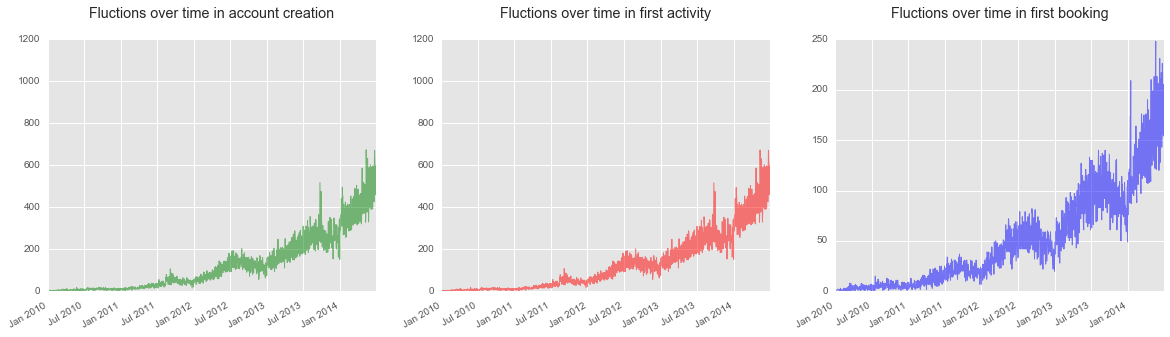

In [12]:
# chart the different date fields and limit the date range to shared range within the training data
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
colours = ['g', 'r', 'b']
vars = ['date_account_created', 'date_first_active', 'date_first_booking']
titles = ['account creation', 'first activity', 'first booking']
for i, var in enumerate(vars):
    df_users[var].value_counts().plot(ax=axes[i], alpha=0.5, legend=False, lw=1, c=colours[i], 
                                   xlim=['2010-01-01','2014-06-30'])
    axes[i].set_title('Fluctions over time in %s\n' % titles[i])

From the graphs above and the correlation calulation below there is an exceptionally strong relationship between the account creation date with both the date of the first activity (0.999479) and first booking date (0.968063; where the dates aren't null). This leads me to think that new users tend to join with the express purpose of making arangements for a trip, but only about a 5th of the time does this initial activity lead to the first booking in short sucession. There is drop off at the end of 2014, but it is due to test set not having the first booking details. So I've set the date range for 2010-01-01 to 2014-06-30 to have a more effective comparison accross the date fields. Also, because the 'date_first_booking'field isn't populated well (33% complete) in any case, I've chosedn to drop it from trhe analysis.

***
## What does user engagement on the airbnb website look like?

The session data seems to hold a rich variety of metrics, but they aren't really well populated (please see below) for action type and action detail with about 20.4% of these field values being populated with "-unknown-". And it would seems like unknowns in action type would also mean unknowns in action detail. But these revelance of thes fields are unclear.

In [13]:
sessions_nan = df_user_sessions.replace('-unknown-', np.nan)
sessions_nan_counts = sessions_nan.isnull().sum().sort_values(ascending=False)
sessions_nan_summary = (sessions_nan_counts / sessions_nan.shape[0]) * 100

print('% of session rows with missing values')
print('-----------------------------')
print(sessions_nan_summary)

% of rows with missing values
-----------------------------
action_type      20.414721
action_detail    20.414446
device_type       1.999283
secs_elapsed      1.287229
action            0.753482
user_id           0.326428
dtype: float64


As the name suggests, there is more detail under the *action_detail* field about the action performed but very little other than the occurance of reservation as a description pops out as relevant. It seems action and action details both hold the same information for these two booking related action types. However, *action_type* looks like it should be the most promising since it is only 0.75% incomplete and there is direct mention of *booking_request* and *booking_response*. But on taking a closer look (see below), it was revealed that that *booking_request* and *booking_response* only represent 18,777 rows, or 0.18% of user session rows, or 6.81% of the 275,562 new users that form the combined test and train sets (assuming that each book record represents a booking per user).

A feature onth the other hand is populated quite well is the type of device that was used to interact with the airbnb website, and it indicates that the majority, 59.43%, of users tended to use their desktop, and a further 26.5% use a Apple mobile device.

In [14]:
df_user_sessions.groupby('device_type').size().sort_values(ascending=False) / df_user_sessions.shape[0] *100

device_type
Mac Desktop                         34.011880
Windows Desktop                     25.157127
iPhone                              19.919411
Android Phone                        7.945287
iPad Tablet                          6.466985
Android App Unknown Phone/Tablet     2.589504
-unknown-                            1.999283
Tablet                               1.323708
Linux Desktop                        0.268487
Chromebook                           0.211474
iPodtouch                            0.077576
Windows Phone                        0.019370
Blackberry                           0.009264
Opera Phone                          0.000643
dtype: float64

Looking at how long the user sessions are by device type, it looks like Blackbery and Windows Phone have the longest recorded time with median time of 70 and 65 minutes respectively. This might not be a good thing and actually point to usability issues for those that use phones that aren't Apple or Android. Android and Apple mobile devices have the lowest median session duration (between 9 and 17 minutes), while desktop and tablets see about twice the session length of mobile devices (excluding Blackberry- and Windows phones). This makes sense since the time required to plan a trip would envolve a lot of research and looking at images or videos and are better suited to tablets and desktops.

Special Thanks to:
* David Gasquez's excellent data exploration work https://www.kaggle.com/davidgasquez/airbnb-recruiting-new-user-bookings/user-data-exploration/notebook
* Kevin Wu https://www.kaggle.com/kevinwu06/airbnb-recruiting-new-user-bookings/airbnb-exploratory-analysis/notebook